In [1]:
import config
import os
import torch
from torch.optim import Adam
from torchinfo import summary
from modules import ViT
from dataset import create_dataloaders
from utils import get_transform, plot_losses_accuracies
from train import train, test
from predict import predict

if not os.path.exists(config.results_path):
    os.makedirs(config.results_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# Check whether image shape is divisible by patch size
assert config.image_size % config.patch_size == 0, print("Image Width is not divisible by patch size")


Using device: cuda (NVIDIA GeForce RTX 3060 Laptop GPU)


In [2]:

# Ininitialise transforms
train_transform = get_transform(data_type="train",
                                data_mean=config.train_mean,
                                data_std=config.train_std,
                                image_size=config.image_size)

valid_transform = get_transform(data_type="valid",
                                data_mean=config.train_mean,
                                data_std=config.train_std,
                                image_size=config.image_size)

test_transform = get_transform(data_type="test",
                                data_mean=config.test_mean,
                                data_std=config.test_std,
                                image_size=config.image_size)

# Setup dataloaders
root_dir = config.data_path
train_loader, valid_loader, test_loader = create_dataloaders(root_dir, 
                                                            train_transform,
                                                            valid_transform,
                                                            test_transform,
                                                            batch_size=config.batch_size,
                                                            datasplit=config.data_split)

In [3]:
# Initialise model
if config.will_load:
    model = torch.load(config.load_path)
else:
    model = ViT(img_size=config.image_size,
                in_channels=config.n_channels,
                patch_size=config.patch_size,
                num_classes=config.n_classes,
                num_transformer_layers=config.n_layers,
                embedding_dim=config.embedding_dim,
                mlp_size=config.mlp_size,
                num_heads=config.n_heads,
                attn_dropout=config.attn_dropout,
                mlp_dropout=config.mlp_dropout,
                embedding_dropout=config.embedding_dropout)

model = model.to(device)
print(next(model.parameters()).device)

# Show model summary
if config.show_model_summary:
    summary(model=model,
        input_size=(config.batch_size,
                    config.n_channels,
                    config.image_size,
                    config.image_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])



cuda:0


cuda


Training: 100%|██████████| 15/15 [21:49<00:00, 87.32s/it]


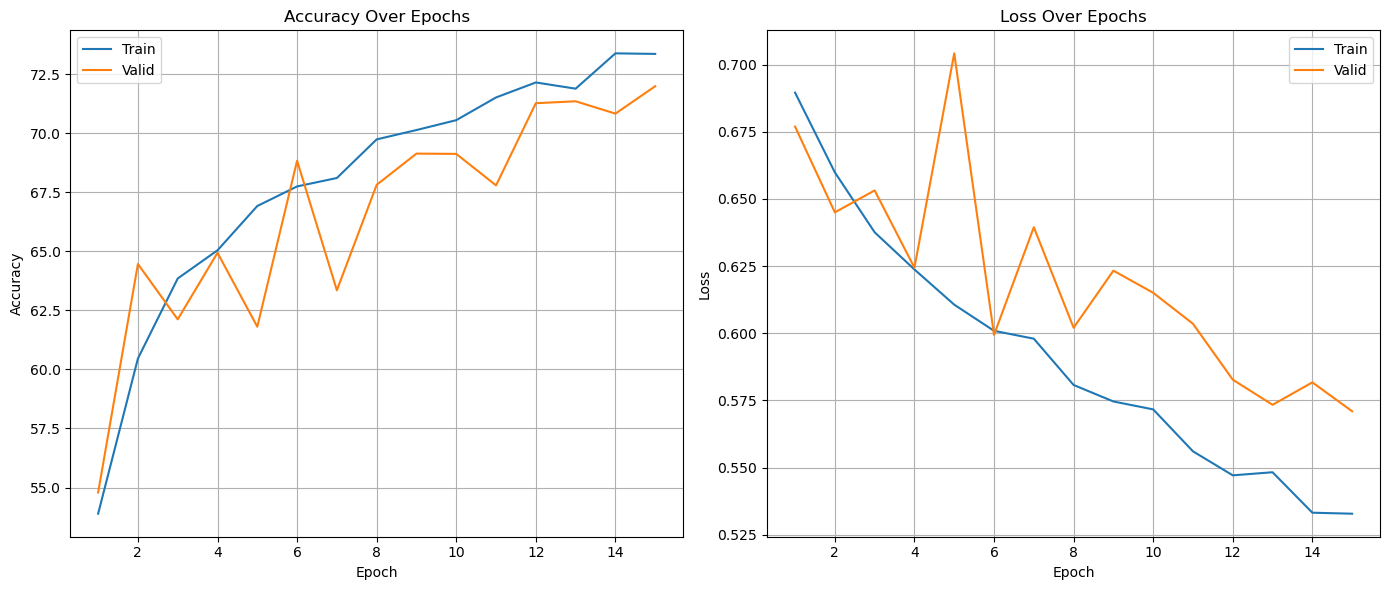

In [4]:
# Initialise loss function and optimiser
optimizer = Adam(model.parameters(), 
            lr=config.learning_rate)

criterion = torch.nn.CrossEntropyLoss()
print(device)

if config.will_train:
    # Train the model
    train_accuracies, valid_accuracies, train_losses, valid_losses = train(model=model,
                                                                        train_loader=train_loader,
                                                                        valid_loader=valid_loader,
                                                                        criterion=criterion,
                                                                        optimizer=optimizer,
                                                                        device=device,
                                                                        n_epochs=config.n_epochs)

    # Plot results
    plot_losses_accuracies(train_accuracies, 
                            valid_accuracies, 
                            train_losses,
                            valid_losses,
                            save_path=config.results_path)

In [5]:
# Save the model
if config.will_save:
    torch.save(model, config.save_path)

# Test the model
if config.will_test:
    test(model=model,
        test_loader=test_loader,
        criterion=criterion,
        device=device)

Testing: 100%|██████████| 141/141 [00:39<00:00,  3.57it/s]

Test loss: 0.73
Test accuracy: 60.72%
